In [1]:
%matplotlib inline
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
from PIL import Image, ImageFilter
from scipy.ndimage.filters import gaussian_filter
from skimage.filters import *
from skimage.transform import *
import os
import math
from math import floor

In [2]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [3]:
def PS(T, r):
    T = np.transpose(T, (1, 2, 0))
    rW = r*len(T)
    rH = r*len(T[0])
    C = len(T[0][0])/(r*r)

    # make sure C is an integer and cast if this is the case
    assert(C == int(C))
    C = int(C)
    
    res = np.zeros((rW, rH, C))

    for x in range(len(res)):
        for y in range(len(res[x])):
            for c in range(len(res[x][y])):
                res[x][y][c] = \
                    T[x // r][y // r][C*r*(y % r) + C*(x % r) + c]
    return res

def PS_inv(img, r):
    r2 = r*r
    W = len(img)/r
    H = len(img[0])/r
    C = len(img[0][0])
    Cr2 = C*r2

    # Make sure H and W are integers
    assert(int(H) == H and int(W) == W)
    H, W = int(H), int(W)

    res = np.zeros((W, H, Cr2))

    for x in range(len(img)):
        for y in range(len(img[x])):
            for c in range(len(img[x][y])):
                res[x // r][y // r][C*r*(y % r) + C*(x % r) + c] = img[x][y][c]
    return res


In [4]:
# hyperparameters
r = 2 # upscaling ratio
blur = 1 # gaussian blur (missing ???)
C = 3 # colour channels
lr_start = 0.01 # learning rate
lr_end = 0.0001
mu = 1e-3 # threshold for lowering the lr (missing ???)
no_learning_threshold = 1e-5 # threshold for stopping training of no improvement has been made for 100 epochs

TESTIng datalaoder iter


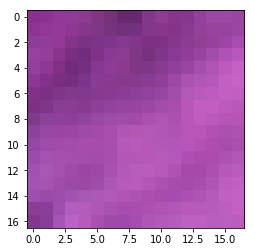

DONE!!!


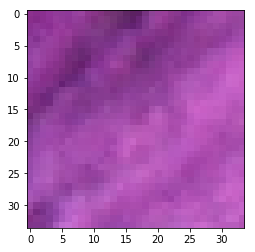

In [5]:
"""
Downsample images
- gaussian blur
- resize by downsample factor (using interpolation)

How To Use:
    function lr_dataset_from_path takes a path to the dataset of HR image png files and returns an ndarray to use for training the model
    
For debugging/showing examples:
    (see bottom of file)
    save_png set to True to save resulting lr images in specified directory.
    !check the param_ varaiables
"""

SUBSAMPLING_STRIDE_SIZE = 14
SUBSAMPLING_SAMPLE_SIZE = 17


# hr_dataset_path: dir to the hr_dataset png files
# downscale: downscale factor, e.g. if original image 64*64 and downscale=2 then result will be 32*32
# returns list of numpy.ndarray representing the lr_images
def lr_dataset_from_path(hr_dataset_path, downscale):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))
    return lr_images(original_images, downscale)  # ndarray of images


def torchDataloader_from_path(hr_dataset_path, downscale, gaussian_sigma):
    original_filenames = os.listdir(hr_dataset_path)
    original_images = []
    for file in original_filenames:
        original_images.append(plt.imread(hr_dataset_path + '/' + file))

    # subsample
    subsamples_hr = []
    subsamples_hr_rev_shuff = []
    for i in range(len(original_images)):
        temp_subsamples = subsample(original_images[i], downscale)
        subsamples_hr += temp_subsamples
        for sample_indx in range(len(temp_subsamples)):
            subsamples_hr_rev_shuff.append(PS_inv(temp_subsamples[sample_indx], downscale))  # labels
    lr_dataset = lr_images(subsamples_hr, downscale, gaussian_sigma)  # ndarray of images

    return toDataloader(lr_dataset, subsamples_hr_rev_shuff)


# Takes list of images and provide LR images in form of numpy array
def lr_images(images_real, downscale, gaussianSigma):
    lr_images = []
    for img in range(len(images_real)):
        img_blurred = gaussian(images_real[img], sigma=gaussianSigma,
                               multichannel=True)  # multichannel blurr so that 3rd channel is not blurred
        lr_images.append(resize(img_blurred, (img_blurred.shape[0] // downscale, img_blurred.shape[1] // downscale)))
    return lr_images


# extract a 17r*17r subsample from original image, no overlap so every pixel appears at most once in output
def subsample(image_real, downscale):
    subsample_size = SUBSAMPLING_SAMPLE_SIZE * downscale
    subsample_stride = SUBSAMPLING_STRIDE_SIZE * downscale
    subsamples = []
    for y in range(math.floor((image_real.shape[0] - (subsample_size - subsample_stride)) / subsample_stride)):
        for x in range(math.floor((image_real.shape[1] - (subsample_size - subsample_stride)) / subsample_stride)):
            ss = image_real[(y * subsample_stride):(y * subsample_stride) + subsample_size,
                 (x * subsample_stride):(x * subsample_stride) + subsample_size]
            subsamples.append(ss)

    return subsamples


# returns a torch Dataloader (to iterate over training data) using the training data samples and traing data labels
def toDataloader(train_data, train_labels):
    labeled_data = []
    for i in range(len(train_data)):
        labeled_data.append([np.transpose(train_data[i], (2, 0, 1)), np.transpose(train_labels[i], (2, 0, 1))])
    trainDataloader = DataLoader(labeled_data)
    return trainDataloader


# ---DEBUG--- uncomment to show first image
# pyplot.imshow(original_images[0])
# pyplot.imshow(lr_dataset[0])

# ----TEST DATALOADER ----
dataloader = torchDataloader_from_path('datasets/T91', r, blur)

print("TESTIng datalaoder iter")
i1, l1 = next(iter(dataloader))
imshow(i1[0])
plt.imshow(PS(l1[0], r))

print("DONE!!!")

In [17]:
use_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(C, 64, 5, padding=2)
        self.conv2 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, r*r*C, 3, padding=1)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = self.conv3(x)
        return x


net = Net()
net.double()

if use_gpu:
    net = net.cuda()

In [19]:
# define loss fuction
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=lr_start, momentum=0.9) # momentum???

In [20]:
losses = []

epoch = 0
last_epoch_loss = float("inf")
ni_counter = 0 # counts the amount of epochs no where no improvement has been made
minibatch_size = 100
epoch_save_interval = 20
model_dest = "models/model_epoch_"

while(True):  # loop over the dataset multiple times
    epoch_loss = 0.0
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs
        inputs, labels = data
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        epoch_loss += outputs.shape[0] * loss.item()
        running_loss += loss.item()
        if i % minibatch_size == minibatch_size - 1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / minibatch_size))
            running_loss = 0.0
    epoch_loss = epoch_loss / len(inputs)
    print(epoch+1, epoch_loss)
    
    improvement = abs(last_epoch_loss - epoch_loss)
    if improvement < no_learning_threshold:
        ni_counter += 1
    if ni_counter >= 100: # stop training if no improvement has been made for 100 epochs
        break
    
    losses.append(epoch_loss / len(inputs))
    last_epoch_loss = epoch_loss
    
    if epoch % epoch_save_interval == 0:
        torch.save(net.state_dict(), model_dest + str(epoch + 1))

    epoch += 1
        

print('Finished Training')

[1,   100] loss: 0.05358
[1,   200] loss: 0.02155
[1,   300] loss: 0.01618
[1,   400] loss: 0.01304
[1,   500] loss: 0.01137
[1,   600] loss: 0.00851
[1,   700] loss: 0.00870
[1,   800] loss: 0.00716
[1,   900] loss: 0.00904
[1,  1000] loss: 0.00447
[1,  1100] loss: 0.00310
[1,  1200] loss: 0.00754
[1,  1300] loss: 0.00459
[1,  1400] loss: 0.00538
[1,  1500] loss: 0.00745
[1,  1600] loss: 0.00760
[1,  1700] loss: 0.00435
[1,  1800] loss: 0.00732
1 20.661159519072687
[2,   100] loss: 0.00705
[2,   200] loss: 0.00321
[2,   300] loss: 0.00431
[2,   400] loss: 0.00351
[2,   500] loss: 0.00482
[2,   600] loss: 0.00536
[2,   700] loss: 0.00454
[2,   800] loss: 0.00416
[2,   900] loss: 0.00602
[2,  1000] loss: 0.00330
[2,  1100] loss: 0.00218
[2,  1200] loss: 0.00501
[2,  1300] loss: 0.00216
[2,  1400] loss: 0.00360
[2,  1500] loss: 0.00444
[2,  1600] loss: 0.00258
[2,  1700] loss: 0.00260
[2,  1800] loss: 0.00412
2 7.731093938004835
[3,   100] loss: 0.00558
[3,   200] loss: 0.00189
[3,   300

[18,   200] loss: 0.00056
[18,   300] loss: 0.00129
[18,   400] loss: 0.00084
[18,   500] loss: 0.00160
[18,   600] loss: 0.00219
[18,   700] loss: 0.00121
[18,   800] loss: 0.00115
[18,   900] loss: 0.00229
[18,  1000] loss: 0.00127
[18,  1100] loss: 0.00076
[18,  1200] loss: 0.00181
[18,  1300] loss: 0.00075
[18,  1400] loss: 0.00147
[18,  1500] loss: 0.00159
[18,  1600] loss: 0.00080
[18,  1700] loss: 0.00078
[18,  1800] loss: 0.00107
18 2.6377010666676703
[19,   100] loss: 0.00275
[19,   200] loss: 0.00055
[19,   300] loss: 0.00127
[19,   400] loss: 0.00082
[19,   500] loss: 0.00158
[19,   600] loss: 0.00216
[19,   700] loss: 0.00120
[19,   800] loss: 0.00114
[19,   900] loss: 0.00226
[19,  1000] loss: 0.00126
[19,  1100] loss: 0.00075
[19,  1200] loss: 0.00179
[19,  1300] loss: 0.00074
[19,  1400] loss: 0.00146
[19,  1500] loss: 0.00157
[19,  1600] loss: 0.00078
[19,  1700] loss: 0.00077
[19,  1800] loss: 0.00105
19 2.6038992595331947
[20,   100] loss: 0.00273
[20,   200] loss: 0.

KeyboardInterrupt: 

In [19]:
torch.save(net.state_dict(), "trained_model")

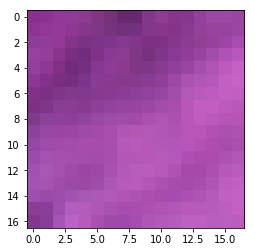

LR


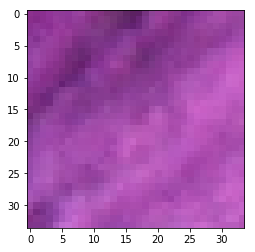

HR


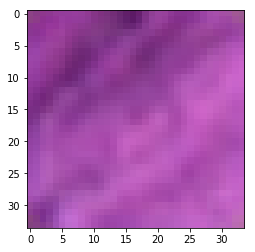

SR


In [10]:
imshow(i1[0])
print("LR")

plt.imshow(PS(l1[0], r))
plt.show()
print("HR")

if use_gpu:
    net.cpu()

result = net(i1.double())
res = result[0].detach().numpy()

if use_gpu:
    net.cuda()
    
plt.imshow(PS(res, r))
plt.show()
print("SR")

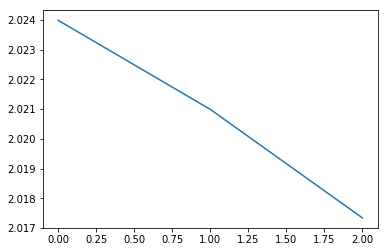

In [11]:
plt.plot(losses)

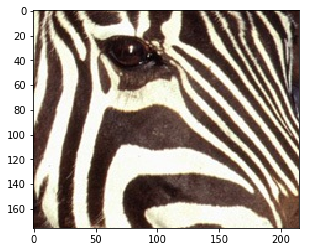

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


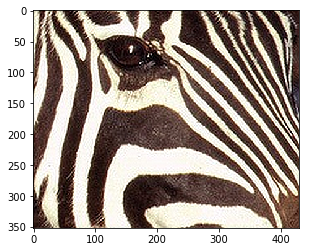

In [12]:
img = plt.imread("datasets/T91/t36.png")

plt.imshow(img)
plt.show()

img = np.transpose(img, (2, 0, 1))
img = torch.Tensor(img).unsqueeze(0).double()
net.cpu()
result = net(img).detach().numpy()
net.cuda()
plt.imshow(PS(result[0], r))